# Predict Future Sales

In this problem I have worked with a challenging time-series dataset consisting of daily sales data, provided by - 1C Company. The goal is to predict total sales for every product and store in the next month. 
* Main methods I used for this project: **LightGBM**         **RMSE Score: 0.820379**

The most important features are:
* standard lag features (target value for X-months ago, target mean value for shop/item_category/items) (X=1,2,12)
* mean target values for item count day for last month for shop/item_category
* sum target values for item count day for last month for shop/item_category
* grouping items into small categories 

Tools I used in this project are: numpy, pandas, sklearn, LightGBM

Basic data analysis is done, including plotting sum and mean of item_cnt_day for each month to find some patterns, exploring missing values, inspecting test set …

Here are few things interesting I found from doing EDA:
- Number of sold items declines over the year
- Data has no missing values
- Not all item in train set are in test set and vice versa

Since the task is to make a monthly prediction, we need to aggregate the data to monthly level before doing any encodings

Lag features are values at prior time steps. I am generating lag features based on ‘item_cnt’ and grouped by ‘shop_id’ and ‘item_id’ .  Time steps are: 1,2, and 12 months.

All sale record before 2014 are dropped, since there would be no lag features before 2014 as we have a 12-month lag.

**These lag features turn out to be the most important features in my dataset, based on LightGBM's importance features**.




## Execution steps

- Kindly install the dependancies before running the cells
    - all dependencies can be installed using -pip install
- Download the data from kaggle website
    - **link: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data**

- Model has been pickled at various stages
- Kindly load the pickled model for predictions if you are unable to train it due to insufficient resources.

### You can also download the zip file containing data, processed dataframes and the pickled model from the drive link provided

- **Link: https://drive.google.com/open?id=1nFBc3Fu8KZ5brij3ePc88wKQEaYG-l4z**

* **Couldn't zip them as they are huge**

## Import the necessary files required

* Define the Data directory appropriately

In [43]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.sparse 
import sklearn
from utils import *
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,make_scorer
from math import sqrt
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


%matplotlib inline
data_path = 'D:/Fall 2018/proj_5/'
seed=1204

## Read the files into pandas dataframes

In [2]:
sales    = pd.read_csv(os.path.join(data_path, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(data_path, 'items.csv'))
item_categories = pd.read_csv(os.path.join(data_path, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(data_path, 'shops.csv'))
test            = pd.read_csv(os.path.join(data_path, 'test.csv.gz'))

## Explore the dataframes

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Plots showing characteristics of Sales data

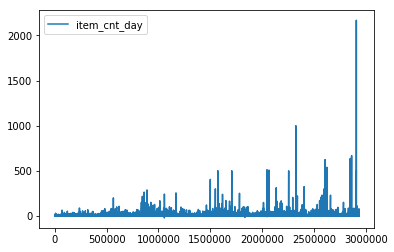

In [8]:
sales[['item_cnt_day']].plot()


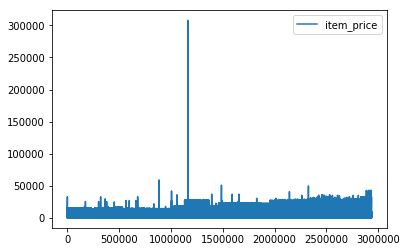

In [9]:
sales[['item_price']].plot()

## Plot showing the variance, trends in the sales data
    - It is important to remove the seasonality and trends for timeseries analysis
    - Convert the data into stationary data wrt time.

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


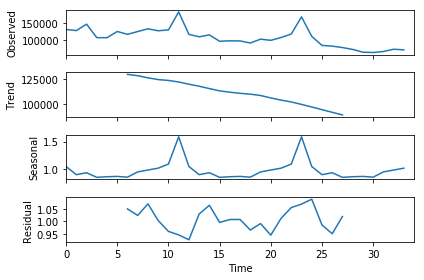

In [10]:
import statsmodels.api as sm
pattern=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
pattern.astype('float')
res = sm.tsa.seasonal_decompose(pattern.values,freq=12,model = 'multiplicative')
fig = res.plot()

### Ignoring the outliers

In [11]:
sales = sales[sales['item_cnt_day']<=1000]
sales = sales[sales['item_price']<100000]

## Merge all data into one dataframe
### Get unique shop and item pairs using permutation, and get the item count for each month they are sold
    - Item, shop and Date together make the index column for the timeseries


In [12]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

g1 = [] 
for block_num in sales['date_block_num'].unique():
    all_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    all_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    g1.append(np.array(list(product(*[all_shops, all_items, [block_num]])),dtype='int32'))

g1 = pd.DataFrame(np.vstack(g1), columns = index_cols,dtype=np.int32)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

all_data = pd.merge(g1, gb, how='left', on=index_cols).fillna(0)
all_data =pd.merge(all_data,items,on=['item_id'],how='left')

gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'shop_block_sum':'sum','shop_block_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_block_sum':'sum','item_block_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

sales =pd.merge(sales,items,on=['item_id'],how='left')
gb = sales.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_cat_block_sum':'sum','item_cat_block_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### Downcast numeric data to 32 bit format, to save space and computation

In [13]:

float_cols = [c for c in all_data if all_data[c].dtype == "float64"]
int_cols =   [c for c in all_data if all_data[c].dtype == "int64"]
all_data[float_cols] = all_data[float_cols].astype(np.float32)
all_data[int_cols]   = all_data[int_cols].astype(np.int32)


In [14]:
all_data.shape

(10913804, 12)

### Exploring the dataframe with all tables combined

In [15]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,shop_block_sum,shop_block_mean,item_block_sum,item_block_mean,item_cat_block_sum,item_cat_block_mean
0,59,22154,0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2017.0,1.092041,18.0,1.0,6094.0,1.053414
1,59,2552,0,0.0,DEEP PURPLE The House Of Blue Light LP,58,2017.0,1.092041,0.0,0.0,287.0,0.969595
2,59,2554,0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,2017.0,1.092041,1.0,1.0,287.0,0.969595
3,59,2555,0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2017.0,1.092041,2.0,1.0,268.0,1.007519
4,59,2564,0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,2017.0,1.092041,5.0,1.0,701.0,0.990113


In [16]:
all_data.to_csv(data_path+'new_sales.csv',index=False)

In [17]:
all_data = pd.read_csv(data_path+'new_sales.csv')

In [18]:
index_cols = ['shop_id', 'item_id', 'date_block_num','item_category_id']
column_to_rename = list(all_data.columns.difference(index_cols))
for i in ['item_name']:
    column_to_rename.remove(i)

In [19]:
column_shop = [i for i in column_to_rename if 'shop_block' in i]
column_item = [i for i in column_to_rename if 'item_block' in i]
column_cat = [i for i in column_to_rename if 'item_cat' in i]
column_all = ['target']
column_key=[['item_id'],['shop_id'],['item_category_id'],['shop_id','item_id']]
column_value = [column_item,column_shop,column_cat,column_all]

## To convert the dynamic timeseries into Stationary timeseries
    - Obtain the lag features using the previous month, previous 2 months and previous 1 year mean and sum values
    - Change column names

In [20]:
shift_range = [1,2,12]
for month_shift in shift_range:
    for k,v in zip(column_key,column_value): 
        index_col = ['date_block_num'] + k
        train_shift = all_data[index_col + v].copy().drop_duplicates()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_{}_behind'.format(x, month_shift) if x in v else x
        train_shift = train_shift.rename(columns=foo)
        all_data = pd.merge(all_data, train_shift, on=index_col, how='left').fillna(0)

In [22]:
all_data.to_pickle(data_path+'new_sales_stationary_features.pickle')

In [49]:
all_data = pd.read_pickle(data_path+'new_sales_stationary_features145.pickle')

In [50]:
clip = 20
cols_to_drop=['target','item_name'] + all_data.columns.values[6:12].tolist()
y = np.clip(all_data.target.values,0,clip)
X = all_data.drop(cols_to_drop,axis=1)
X.drop('date_block_num',axis=1,inplace=True)

In [78]:
test = pd.read_csv(os.path.join(data_path, 'test.csv'))

## baseline model: Logistic Regression

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
lr_model = lr()
lr_model.fit(x_train,y_train)
pred = lr.predict(x_test)
sqrt(mean_squared_error(y_test,pred))

## LightGBM model

In [52]:
lgb_params = {
               'colsample_bytree': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 128, 
               'subsample': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'regression', 
               'bagging_seed': 128, 
               'num_leaves': 128,
               'bagging_freq':1,
               'seed':1204
              }

In [68]:
lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 400, 
                      lgb.Dataset(X, label=y), verbose_eval=10)

[10]	valid_0's rmse: 1.10665
[20]	valid_0's rmse: 1.02896
[30]	valid_0's rmse: 0.978728
[40]	valid_0's rmse: 0.946946
[50]	valid_0's rmse: 0.923833
[60]	valid_0's rmse: 0.908153
[70]	valid_0's rmse: 0.896666
[80]	valid_0's rmse: 0.888134
[90]	valid_0's rmse: 0.881107
[100]	valid_0's rmse: 0.875752
[110]	valid_0's rmse: 0.871032
[120]	valid_0's rmse: 0.866972
[130]	valid_0's rmse: 0.863337
[140]	valid_0's rmse: 0.859978
[150]	valid_0's rmse: 0.85696
[160]	valid_0's rmse: 0.854354
[170]	valid_0's rmse: 0.851614
[180]	valid_0's rmse: 0.849408
[190]	valid_0's rmse: 0.847322
[200]	valid_0's rmse: 0.845511
[210]	valid_0's rmse: 0.843737
[220]	valid_0's rmse: 0.842172
[230]	valid_0's rmse: 0.84062
[240]	valid_0's rmse: 0.83911
[250]	valid_0's rmse: 0.837434
[260]	valid_0's rmse: 0.83606
[270]	valid_0's rmse: 0.834713
[280]	valid_0's rmse: 0.833456
[290]	valid_0's rmse: 0.832027
[300]	valid_0's rmse: 0.83086
[310]	valid_0's rmse: 0.829301
[320]	valid_0's rmse: 0.828276
[330]	valid_0's rmse: 0.

## LightGBM performs best

In [79]:
test.drop(['ID'],axis=1,inplace=True)

### Predict on test set

In [80]:
test_pred = lgb_model_full.predict(test,100)


In [81]:
test_pred

array([0.59494252, 0.57067298, 0.5897069 , ..., 0.5646766 , 0.5646766 ,
       0.64171515])

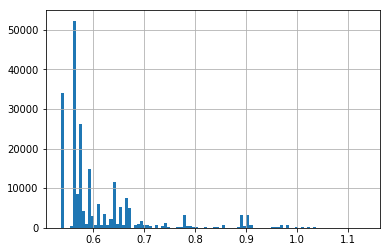

In [82]:
pd.Series(test_pred).hist(bins=100)

### Save the predictions

In [83]:
test_p = pd.DataFrame(test_pred,columns = ['item_cnt_month'])

In [84]:
test_p.to_csv(data_path+'predictions.csv')

### Pickle trained model for future use

In [47]:
joblib.dump(lgb_model_full, data_path+'lgb.pkl')

# load model
#gbm_pickle = joblib.load('lgb.pkl')

['D:/Fall 2018/proj_5/lgb.pkl']

# Final RMSE on Validation set: 0.820379